# Project 1 Part 2: Translation with a Sequence to Sequence Network and Attention

teaching a neural network to translate from French to English.

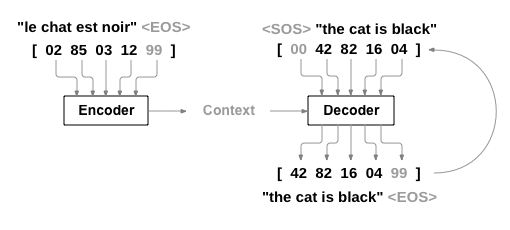

This is made possible by the simple but powerful idea of the **sequence to sequence network**, in which **two recurrent neural networks** work together to transform one sequence to another. 
- An encoder network condenses an input sequence into a vector
- a decoder network unfolds that vector into a new sequence.

## 问题记录

- 1. pytorch基础教程
- 2. encoder-decoder model architecture
- 3. nn.GRU() 使用方式
- 4. 

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import string

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Loading Data File
上传翻译用的数据文件，这次的数据文件全部都在`/harddisk1/SZC-Project/NLP-learning/RNNs/data/eng-fra.txt`内

### Data Preprocessing
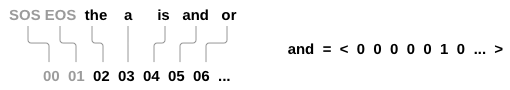

- 在之前的任务当中，one-hot encoding 被用作编码字符，字符只有有57个
- 假如使用 one-hot encoding 对word进行编码，那么假如文本有10000个word，那么one-hot encoding 的维度为10000，那么这个维度就太大了。
- 为了简化问题，会缩减单词数量，只保留最常用的几千个单词
- 图中展示了一个例子，其中单词“and”被表示为一个一热向量。假设词汇表中“and”的索引是7（从0开始计数），那么它的向量表示就是 [0, 0, 0, 0, 0, 0, 1, 0, ...]，其中第7位是1，其余都是0。

为了管理这些单词的index，创建辅助类 `lang class`， 包含两个dict：
- `word2index`: 将单词映射到索引
- `index2word`: 将索引映射回单词
还有一个函数`word2count`，用于记录每个单词的词频

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self,name):
        self.name = name
        self.word2index = {}
        self.index2word = {}
        self.word2count = {}
        self.n_words = 0
    
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)


# example of Lang
lang1 = Lang("eng")
lang2 = Lang("Fran")
sentence = "I am a man"
words = ["SOS", "EOS", "the", "a", "is", "and", "or"]
for word in words:
    lang1.add_word(word)

# word2index
print(lang1.word2index["and"])

# index2word
print(lang1.index2word[1])

# word2count
print(lang1.word2count)

lang2.add_sentence(sentence)
print(lang1.word2index)
print(lang2.word2index)

5
EOS
{'SOS': 1, 'EOS': 1, 'the': 1, 'a': 1, 'is': 1, 'and': 1, 'or': 1}
{'SOS': 0, 'EOS': 1, 'the': 2, 'a': 3, 'is': 4, 'and': 5, 'or': 6}
{'I': 0, 'am': 1, 'a': 2, 'man': 3}


In [3]:
# make files into Unicode

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def normalizeString(s):
    # 调用 unicodeToAscii 并将字符串转换为小写，去除首尾空格
    s = unicodeToAscii(s.lower().strip())
    # 在标点符号前后添加空格
    s = re.sub(r"([.!?])", r" \1", s)
    # 将非字母字符替换为空格
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    # 去除多余的空格并返回结果
    return s.strip()

input_str = "Héllô, wörld! How's it going?"
normalized_str = normalizeString(input_str)
print(normalized_str)

hello world how s it going


In [4]:
# read the data files
# 从文件中读取双语句子对，并对其进行标准化处理，同时创建两个语言对象（Lang 类的实例），分别用于表示输入语言和输出语言

"""
parameters:
- lang1 和 lang2:
    - 表示两种语言的标识符（例如 "eng" 和 "fra"）。
    - 这些标识符将用于构建文件名
- reverse=False
    - 如果设置为 True，则会交换输入语言和输出语言的角色
"""
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # read the file and split into lines
    lines = open("data/%s-%s.txt" % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs


input_lang,output_lang,pairs = readLangs('eng','fra')

Reading lines...


In [5]:
# 过长的句子或过于复杂的句子可能会导致梯度消失或梯度爆炸的问题，尤其是在使用 RNN 或 LSTM 时。此外，过长的句子也会增加模型的学习难度。

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", 
    "i m ",
    "he is", 
    "he s ",
    "she is", 
    "she s ",
    "you are", 
    "you re ",
    "we are", 
    "we re ",
    "they are", 
    "they re "
)

def filterPair(p):
    """
    parameters:
    - p: 一个包含两个字符串的列表或元组，代表一个句子对
    - 功能：
        - 检查句子的单词数小于 MAX_LENGTH（即10个单词）
        - 检查英语句子（p[1]）是否以 eng_prefixes 中的任何一个前缀开头。
    """
    
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    """
    功能：
        - 使用列表推导式遍历 pairs 中的每一个句子对，并调用 filterPair 函数进行筛选。
        - 返回一个新的列表，其中只包含通过 filterPair 筛选后的句子对。
    """

    return [pair for pair in pairs if filterPair(pair)]


The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs

- Normalize text, filter by length and content

- Make word lists from sentences in pairs

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" %len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)


Reading lines...
Read 135842 sentence pairs
Trimmed to 11464 sentence pairs
Counting words...
Counted words:
fra 4625
eng 2986


In [55]:
print(random.choice(pairs))

['tu es fabuleux', 'you are fabulous']


# The Seq2Seq Model

Seq2Seq模型，又或者说是Encoder-Decoder模型，具有两个RNN模型，一个将sentence读进去产生出单一vertor，decoder是将vector变成翻译的句子

- 1. 序列预测与单个 RNN 的局限性
    - 在传统的序列预测任务中（例如使用单个 RNN），输入和输出是一一对应的。也就是说，对于每个输入时间步（time step），模型都会生成一个对应的输出。
    - 例如，在语音信号处理或简单的字符预测任务中，输入序列的长度和输出序列的长度通常是相同的，并且顺序也保持一致。
- 2. Seq2Seq 模型的特点
    - 使用一个 编码器（Encoder） 将输入序列压缩成一个固定长度的上下文向量（context vector 或 hidden state）。
    - 然后使用一个 解码器（Decoder），根据这个上下文向量生成目标序列。
    - 这种设计使得 Seq2Seq 模型能够摆脱输入序列长度和输出序列长度必须相等的限制，同时也允许**输入和输出之间的顺序**不同 
        - 某些语言的语序可能与目标语言不同（如主谓宾结构的变化）。Seq2Seq 模型可以通过上下文向量捕捉这些语义信息，并在解码时重新排列单词顺序

## The Encoder
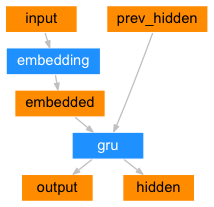
- 输入（Input）:
    - 每个输入单词首先被转换为一个词嵌入向量。
- 嵌入（Embedding）:
    - 词嵌入层将输入单词转换为一个固定长度的向量表示。
- 嵌入向量（Embedded）:
    - 嵌入后的向量与上一时间步的隐藏状态一起作为 GRU 的输入。
- GRU 处理:
    - GRU 单元接收当前时间步的嵌入向量和上一时间步的隐藏状态，并输出一个新的隐藏状态和一个输出向量。
- 输出（Output）:
    - GRU 输出的向量可以被解码器使用来生成目标序列。
- 隐藏状态（Hidden）:
    - 新的隐藏状态被传递给下一个时间步的 GRU 单元，以保持上下文信息。


## The Decoder
### Simple Decoder
在最简单的encoder-decoder模型中，一般使用encoder的最后一个output。
最后的output会称为`context vector`，这个context vector会被用作decoder的hidden的最初始状态，即：

last output from encoder -> initial hidden to decoder

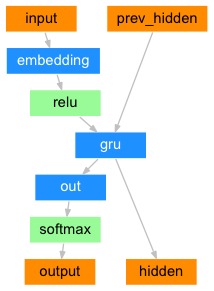

- 解码器在每个时间步都会接收一个输入标记和一个隐藏状态。
- 初始时间步的输入标记是 <SOS>，表示目标序列的开始。
- 初始时间步的隐藏状态是编码器的最后一个隐藏状态（即上下文向量），它包含了输入序列的上下文信息。
- 随着解码器逐步生成目标序列，输入标记会变为前一个时间步生成的单词，而隐藏状态则由解码器自身的GRU或LSTM单元更新。

#### 困难点理解：
- 1. SOS_token 是什么？
    - <SOS> 是“Start Of String”的缩写，表示目标序列的开始。
    - 在解码器的第一步中，decoder_input 被初始化为 <SOS>，告诉解码器从哪里开始生成目标序列。

- 2. 为什么需要 detach()？
    - 在推理模式下，topi.squeeze(-1).detach() 中的 detach() 是为了切断当前预测与历史梯度的联系，避免梯度回传到之前的预测步骤。??

- 3. 为什么要用 log_softmax？
    - log_softmax 是一种数值稳定的概率计算方法，常用于计算交叉熵损失函数。
    - 它将输出转换为对数概率分布，便于后续计算损失值。

In [ ]:
# Encoder defination

class EncoderRNN(nn.Module):
    """parameters
    - input_size: 表示输入词汇表的大小，即有多少个不同的单词或token。
    - hidden_size: 表示隐藏层的维度大小，也就是嵌入向量和GRU输出的维度。
    - dropout_p: Dropout的比例，用于防止过拟合，默认值为0.1。
    """


    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN,self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size) # 将输入的离散单词索引转换为稠密的向量表示（词嵌入）。每个单词都会被映射到一个hidden_size维的向量空间。
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True) # 这里设置batch_first=True意味着输入张量的第一个维度是批量大小（batch size），形状为(batch_size, sequence_length, hidden_size)。
        self.dropout = nn.Dropout(dropout_p) 
    
    """
    output, hidden = self.gru(embedded)
        - 将嵌入后的向量输入到GRU中进行处理。
        - GRU返回两个结果：
            - output: 每个时间步的输出，形状为(batch_size, sequence_length, hidden_size)。
            - hidden: 最后一个时间步的隐藏状态，形状为(1, batch_size, hidden_size)。这个隐藏状态包含了整个输入序列的上下文信息。
    """
    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded) # embedded的大小是什么？
        return output, hidden

# decoder module

class DecoderRNN(nn.Module):
    """parameters
    - hidden_size: 隐藏维度的大小，与encoder的hidden_size相同
    - output_size: 输出维度的大小，与单词表大小相同
    """
    def __init__(self, hidden_size, output_size):
        """初始化内容：
        - nn.Embedding(output_size, hidden_size):
            - 将目标序列中的当前 word 转化为 稠密的向量表示
        - nn.GRU(hidden_size, hidden_size, batch_first=True):
            - GRU用于处理输入序列，并逐步生成输出序列。
            - 设置batch_first=True意味着输入张量的第一个维度是批量大小（batch size）
            - 形状为(batch_size, sequence_length, hidden_size)。
        - nn.Linear(hidden_size, output_size):
            - 这是一个全连接层，将GRU的输出映射到目标词汇表的大小，从而生成每个时间步的预测概率分布
        """
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, bath_first=True)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward_step(self, input, hidden):
        """parameters:
        - input: 当前时间步的输入标记（通常是上一个时间步生成的单词）
        - hidden: 当前时间步的隐藏状态（来自上一时间步的隐藏状态或编码器的上下文向量）
        - output: 当前时间步的预测概率分布。
        """
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        """parameters:
        - encoder_outputs: 编码器的输出（通常在注意力机制中使用，这里未用到）
        - coder_hidden: 编码器的最后一个隐藏状态（上下文向量），作为解码器的初始隐藏状态
        - target_tensor: 目标序列的标记（仅在训练时提供）。如果为None，则表示解码器处于推理模式。
        """

        """Steps:
        - 1. 初始化解码器输入和隐藏状态:
            - decoder_input: 初始化为<SOS>标记，表示目标序列的开始。
            - decoder_hidden: 初始化为编码器的最后一个隐藏状态（上下文向量）,即encoder_hidden
        - 2. 循环生成目标序列:
            - 循环MAX_LENGTH次，逐步生成目标序列。
        - 3. 单步解码:
            - 调用forward_step函数，生成当前时间步的输出和更新隐藏状态。
            - decoder_output, decoder_hidden
        - 4. 教师强制机制（Teacher Forcing）:
            - 如果提供了target_tensor（训练模式），使用目标序列中的实际标记作为下一时间步的输入（教师强制）。
            - 否则，使用当前时间步的预测结果作为下一时间步的输入。
        - 5. 收集所有输出:
            - 将每一步的输出收集到decoder_outputs列表中。
        - 6. 后处理:
            - 将所有输出拼接在一起，并应用log_softmax计算最终的概率分布。
        """
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill(SOS_token) # SOS_token ??
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)
            if target_tensor is not None:
                # 训练状态，使用教师强制机制
                # Teacher Forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach() # detach from history as input
        
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop




------------------------
# 简单的seq2seq模型训练与评估
训练需要哪些东西呢？
首先我连encoder-decoder architecture不清楚，这个需要我来想清楚
我认为我需要将翻译用的数据，变成tensor，然后输入到encoder和decoder内，查看这个流程

In [61]:
# 简化版本的encoder和decoder
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderRNN(nn.Module):
    # input_size:特征维度，即词库大小
    def __init__(self, input_size, hidden_size, dropout_p):
        super(EncoderRNN,self).__init__()
        self.embedded = nn.Embedding(input_size, hidden_size)
        # batch_first的原因需要结合dataloader
        self.gru = nn.GRU(input_size=hidden_size,hidden_size=hidden_size,batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
    
    def forward(self, input):
        # input shape: batch_size, sequence_length, 词库长度
        output = self.embedded(input)
        output = self.dropout(output)
        # 为什么只输入了output,gru的输入应该还有hidden
        output,hidden = self.gru(output) 
        return output, hidden

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p):
        super(DecoderRNN, self).__init__()
        self.embedded = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.out = nn.Linear(in_features=hidden_size, out_features=output_size)
    
    def forward_step(self, input, hidden):
        embedded = self.embedded(input)
        output = F.relu(embedded)
        output, hidden = self.gru(output,hidden)
        output = self.out(output)
        return output, hidden

    def forward(self, encoder_outputs, encoder_hidden,label_tensors=None):
        batch_size = encoder_outputs.size(0)

        # 第一个输入的肯定是SOS，就是认为是empty的vector
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)
            if label_tensors is not None:
                # 开启教师模式，下一个input就是正确的标签label
                decoder_input = label_tensors[:,i].unsqueeze(1) # 在指定位置为张量添加一个新的维度（即增加一个大小为 1 的维度）
            else:
                # 如果没有教师模式，那么就应该从output中找到最高概率的那个输出
                _, topi = decoder_output.topk(1) # 返回1个最大的值
                # topi: 包含最大值对应的索引，形状为 (batch_size, 1)
                decoder_input = topi.squeeze(-1).detach() 
                # squeeze 是 PyTorch 中的一个函数，用于移除指定维度上大小为 1 的维度。
                # detach 是 PyTorch 中的一个方法，用于将张量从计算图中分离出来。分离后的张量不再参与梯度计算，也不会影响反向传播。
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None

In [8]:
# dataloader和训练函数
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang,sentence):
    indexes = [lang.word2index[word] for word in sentence.split(" ")]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1,-1) #参数 (1, -1) 表示将张量 reshape 成一个形状为 (1, x) 的二维张量

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng','fra',True)

    n = len(pairs)
    input_ids, target_ids = np.zeros((n,MAX_LENGTH), dtype=np.int32), np.zeros((n,MAX_LENGTH), dtype=np.int32)

    for idx, (input_pair, target_pair) in enumerate(pairs):
        input_id = indexesFromSentence(input_lang, input_pair)
        target_id = indexesFromSentence(output_lang, target_pair)
        input_id.append(EOS_token)
        target_id.append(EOS_token)
        input_ids[idx, :len(input_id)] = input_id
        target_ids[idx, :len(target_id)] = target_id

    train_data = TensorDataset(torch.LongTensor(input_ids),
                                torch.LongTensor(target_ids))
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

input_lange, output_lange, dataloader = get_dataloader(64)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11464 sentence pairs
Counting words...
Counted words:
fra 4625
eng 2986


In [78]:
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs,_ ,_ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()
    
    return total_loss / len(dataloader)


def Train_function(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


hidden_size = 128
batch_size = 64
dropout_p = 0.1
n_epochs = 100
learning_rate = 0.001

input_lang, target_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size, dropout_p).to(device)
decoder = DecoderRNN(hidden_size, target_lang.n_words, dropout_p).to(device)

losses = Train_function(train_dataloader, encoder, decoder, n_epochs, learning_rate, print_every=5, plot_every=5)
showPlot(losses)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11464 sentence pairs
Counting words...
Counted words:
fra 4625
eng 2986
0m 3s (- 0m 58s) (5 5%) 1.9761
0m 6s (- 0m 55s) (10 10%) 1.1063
0m 9s (- 0m 52s) (15 15%) 0.7710
0m 12s (- 0m 49s) (20 20%) 0.5563
0m 15s (- 0m 46s) (25 25%) 0.4070
0m 18s (- 0m 43s) (30 30%) 0.3024
0m 21s (- 0m 40s) (35 35%) 0.2291
0m 24s (- 0m 37s) (40 40%) 0.1764
0m 28s (- 0m 34s) (45 45%) 0.1384
0m 31s (- 0m 31s) (50 50%) 0.1100
0m 34s (- 0m 27s) (55 55%) 0.0905
0m 37s (- 0m 24s) (60 60%) 0.0751
0m 40s (- 0m 21s) (65 65%) 0.0639
0m 43s (- 0m 18s) (70 70%) 0.0558
0m 46s (- 0m 15s) (75 75%) 0.0495
0m 49s (- 0m 12s) (80 80%) 0.0444
0m 53s (- 0m 9s) (85 85%) 0.0409
0m 56s (- 0m 6s) (90 90%) 0.0376
0m 59s (- 0m 3s) (95 95%) 0.0351
1m 2s (- 0m 0s) (100 100%) 0.0337


# Evaluation

In [82]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_tensor = input_tensor.to(device)
        encoder_output, encoder_hidden = encoder(input_tensor)
        decoder_output, decoder_hidden,_ = decoder(encoder_output, encoder_hidden, label_tensors=None)
        
        _, topi = decoder_output.topk(1)
        decoder_ids = topi.squeeze()
        decoder_words = []
        for idx in decoder_ids:
            if idx.item() == EOS_token:
                decoder_words.append('<EOS>')
                break
            decoder_words.append(output_lang.index2word[idx.item()])
    return decoder_words
        
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = " ".join(output_words)
        print('<', output_sentence)
        print("")

encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, n=20)

> c est vous qui m avez forme
= you re the one who trained me
< you re the one who trained me <EOS>

> vous etes deux fois plus fort que moi
= you are twice as strong as me
< you are twice as strong as me <EOS>

> tu es tellement paranoiaque
= you re so paranoid
< you re so mean <EOS>

> tu as tort dans ce cas
= you re wrong in this case
< you re wrong in this case <EOS>

> je suis desole je n ai pas saisi cela
= i m sorry i didn t catch that
< i <EOS>

> tu es tellement impatient avec moi
= you re so impatient with me
< you re so impatient with me <EOS>

> j ai egalement dix sept ans
= i am seventeen years old too
< i <EOS>

> nous sommes ambitieuses
= we re ambitious
< we are french <EOS>

> nous en avons assez d attendre
= we re tired of waiting
< we re tired of waiting in done <EOS>

> nous sommes a peu pres de la meme taille
= we re about the same height
< we re about the same height <EOS>

> vous etes malade
= you re sick
< you re sick <EOS>

> nous ne sommes pas encore desespere

---------------------